In [1]:
from os import makedirs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.stats import multivariate_normal
from scipy.spatial.distance import euclidean


from skimage.morphology import disk
from skimage.filters import gaussian
from skimage.util import crop, img_as_ubyte

from skimage.measure import regionprops_table
from skimage.transform import resize, rotate
from skimage.io import imsave

In [2]:
def gaussian_spot(mu=[0, 0], cov=[[1, 0], [0, 1]], size=100):
    x = np.linspace(-10, 10, size)
    y = np.linspace(-10, 10, size)
    coord = np.meshgrid(x, y)
    coord = np.stack(coord, axis=-1)
    density = multivariate_normal(mu, cov).pdf(coord)
    return density


def generate_points(size, pad, n_points, min_dist, MAX_FAIL=1_000):
    points = []
    minmax = (0+pad, size-pad)
    dist_respect = True
    N_PTS = n_points
    n_fail = 0
    while n_points != 0 and n_fail <= MAX_FAIL:
        x = np.random.randint(*minmax)
        y = np.random.randint(*minmax)
    
        # check min_dist constraint between new pts and others pts
        for px, py in points:
            d = euclidean([x, y], [px, py])
            if d > min_dist:
                dist_respect = True
                continue
            else:
                dist_respect = False
                n_fail += 1
                break
        
        if n_fail > MAX_FAIL:
            raise Exception(f"Failing to find {N_PTS} points with: minimum distance: {min_dist} and range x:{minmax}, y:{minmax}")
        
        if dist_respect:
            points.append([x, y])
            n_points -= 1
            n_fail = 0 #reset fail for the next pts        

    return points


In [3]:
def get_random_photoreceptor(n_sample=10, sc=3, output_size=100):
    var_x = sc + np.abs(np.random.normal(sc, sc, n_sample))
    var_y = sc + np.abs(np.random.normal(sc, sc, n_sample))
    vars = np.stack([var_x, var_y], axis=-1)

    photos_list, masks_list = [], []
    for vx, vy in vars:    
        # get a spot (only var(y) change in cov matrix)
        spot = gaussian_spot(cov=[[vx, 0], [0, vy]], size=output_size*2)

        # randomly rotate it
        spot = rotate(spot, np.random.randint(0, 360))

        # randomly change intensity
        max_fold = 1/spot.max() #avoid exceeding 1, calc max fold
        spot *= np.random.uniform(0.3 * max_fold , 0.95 * max_fold)

        #random crop (zoom effect)
        trim = np.random.randint(0, output_size * 0.05)
        spot = crop(spot, (trim, trim))

        # resize it
        spot = resize(spot, (output_size, output_size))

        # calc binary mask 
        mask = spot.copy()
        mask[mask < 3*mask.mean()] = 0
        mask[mask > 3*mask.mean()] = 1
        mask = mask.astype(np.uint8)

        photos_list.append(spot)
        masks_list.append(mask)
        
    return photos_list, masks_list

In [4]:
def fake_ommatidia(n_photo=5, canvas_size=400, photo_size=100, spacing=30):
    """
    Generate fake ommatidia img. 
    'spacing' parameter is the minimum space in pixel between each photoreceport. Warning, 
    if 'n_photo' is too high or 'canvas_size' is too low in comparaison to 'spacing' it will fail.
    """
    
    if canvas_size  < photo_size:
        raise ValueError("'canvas_size' must be >= to 'photo_size'")

    shape = (canvas_size, canvas_size)
    canvas, label = np.zeros(shape), np.zeros(shape)
    pad = int(photo_size/2)

    #points = generate_points(((0+pad, canvas_size-pad)), n_photo, min_dist=spacing) #change args
    points = generate_points(canvas_size, pad, n_photo, min_dist=spacing)
    photo, mask = get_random_photoreceptor(n_sample=n_photo, output_size=photo_size)

    for idx, (x, y) in enumerate(points):
        xi, xm = x-pad, x+pad
        yi, ym = y-pad, y+pad
        
        canvas[yi:ym, xi:xm] = np.maximum(canvas[yi:ym, xi:xm], photo[idx])
        label[yi:ym, xi:xm] = np.maximum(label[yi:ym, xi:xm], (1+idx) * mask[idx]) 

    label = label.astype(np.uint8)

    return canvas, label


In [5]:
def fake_vignette(img, label, vignette=False, crop_width=0, sigma_blur=1, sigma_blur_background=3, sigma_noise_background=0.05):

    # make background
    mean_back = np.random.uniform(0.05, 0.1)
    back = np.abs(np.random.normal(mean_back, sigma_noise_background, (10, 10))) # low resolution random noise
    back = resize(back, img.shape) # interpolation to the target size
    back = gaussian(back, sigma=sigma_blur_background) # blur 
    
    # overlay image to the backgroung 
    vign = np.maximum(img, back)
    
    # add blur
    vign = gaussian(vign, sigma=sigma_blur)
    
    # cropping
    label = crop(label, crop_width)
    vign = crop(vign, crop_width)

    if vignette:
        size = vign.shape[0]
        ray = int(size/2) if not size%2 == 0 else int(size/2) - 0.5
        vign *= disk(ray)

    return vign, label


def get_boxes(label, name=""):
    boxes = pd.DataFrame(regionprops_table(label))
    boxes.columns = ["filename", "ymin", "xmin", "ymax", "xmax"] #rename
    boxes["filename"] = name
    boxes["class"] = "photoreceptor"
    boxes = boxes[["filename", "class", "xmin", "ymin", "xmax", "ymax"]] #reorder
    return boxes

def draw_boxes(boxes, im):
    for i, v in boxes.iterrows():
        xy = (v["xmin"], v["ymin"])
        w = v["xmax"] - v["xmin"]
        h = v["ymax"] - v["ymin"]
        r = Rectangle(xy, w, h, fill=False, color="red")
        im.add_patch(r)

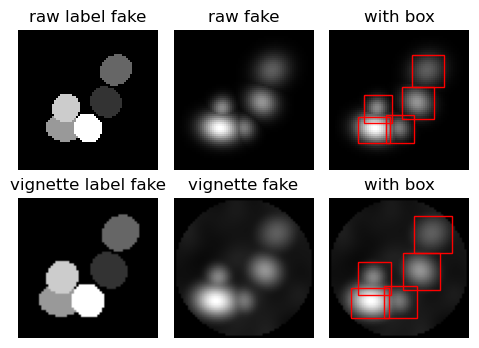

In [6]:
im_raw, lb_raw = fake_ommatidia(n_photo=5, canvas_size=70, photo_size=40, spacing=10) #70x70 image
im_vign, lb_vign = fake_vignette(im_raw, lb_raw, crop_width=5, vignette=True) #60x60 image
boxes_raw = get_boxes(lb_raw)
boxes_vign = get_boxes(lb_vign)


title = ["raw label fake", "raw fake", "with box",
        "vignette label fake", "vignette fake", "with box"]

imgs = [lb_raw, im_raw, im_raw,
        lb_vign, im_vign, im_vign]

f, a = plt.subplots(ncols=3, nrows=2, figsize=(6, 4), gridspec_kw=dict(wspace=0.01, hspace=0.2))
for i, x in enumerate(a.ravel()):
    x.axis("off")
    x.set_title(title[i])
    x.imshow(imgs[i], cmap="gray")

draw_boxes(boxes_raw, a[0, 2])
draw_boxes(boxes_vign, a[1, 2])

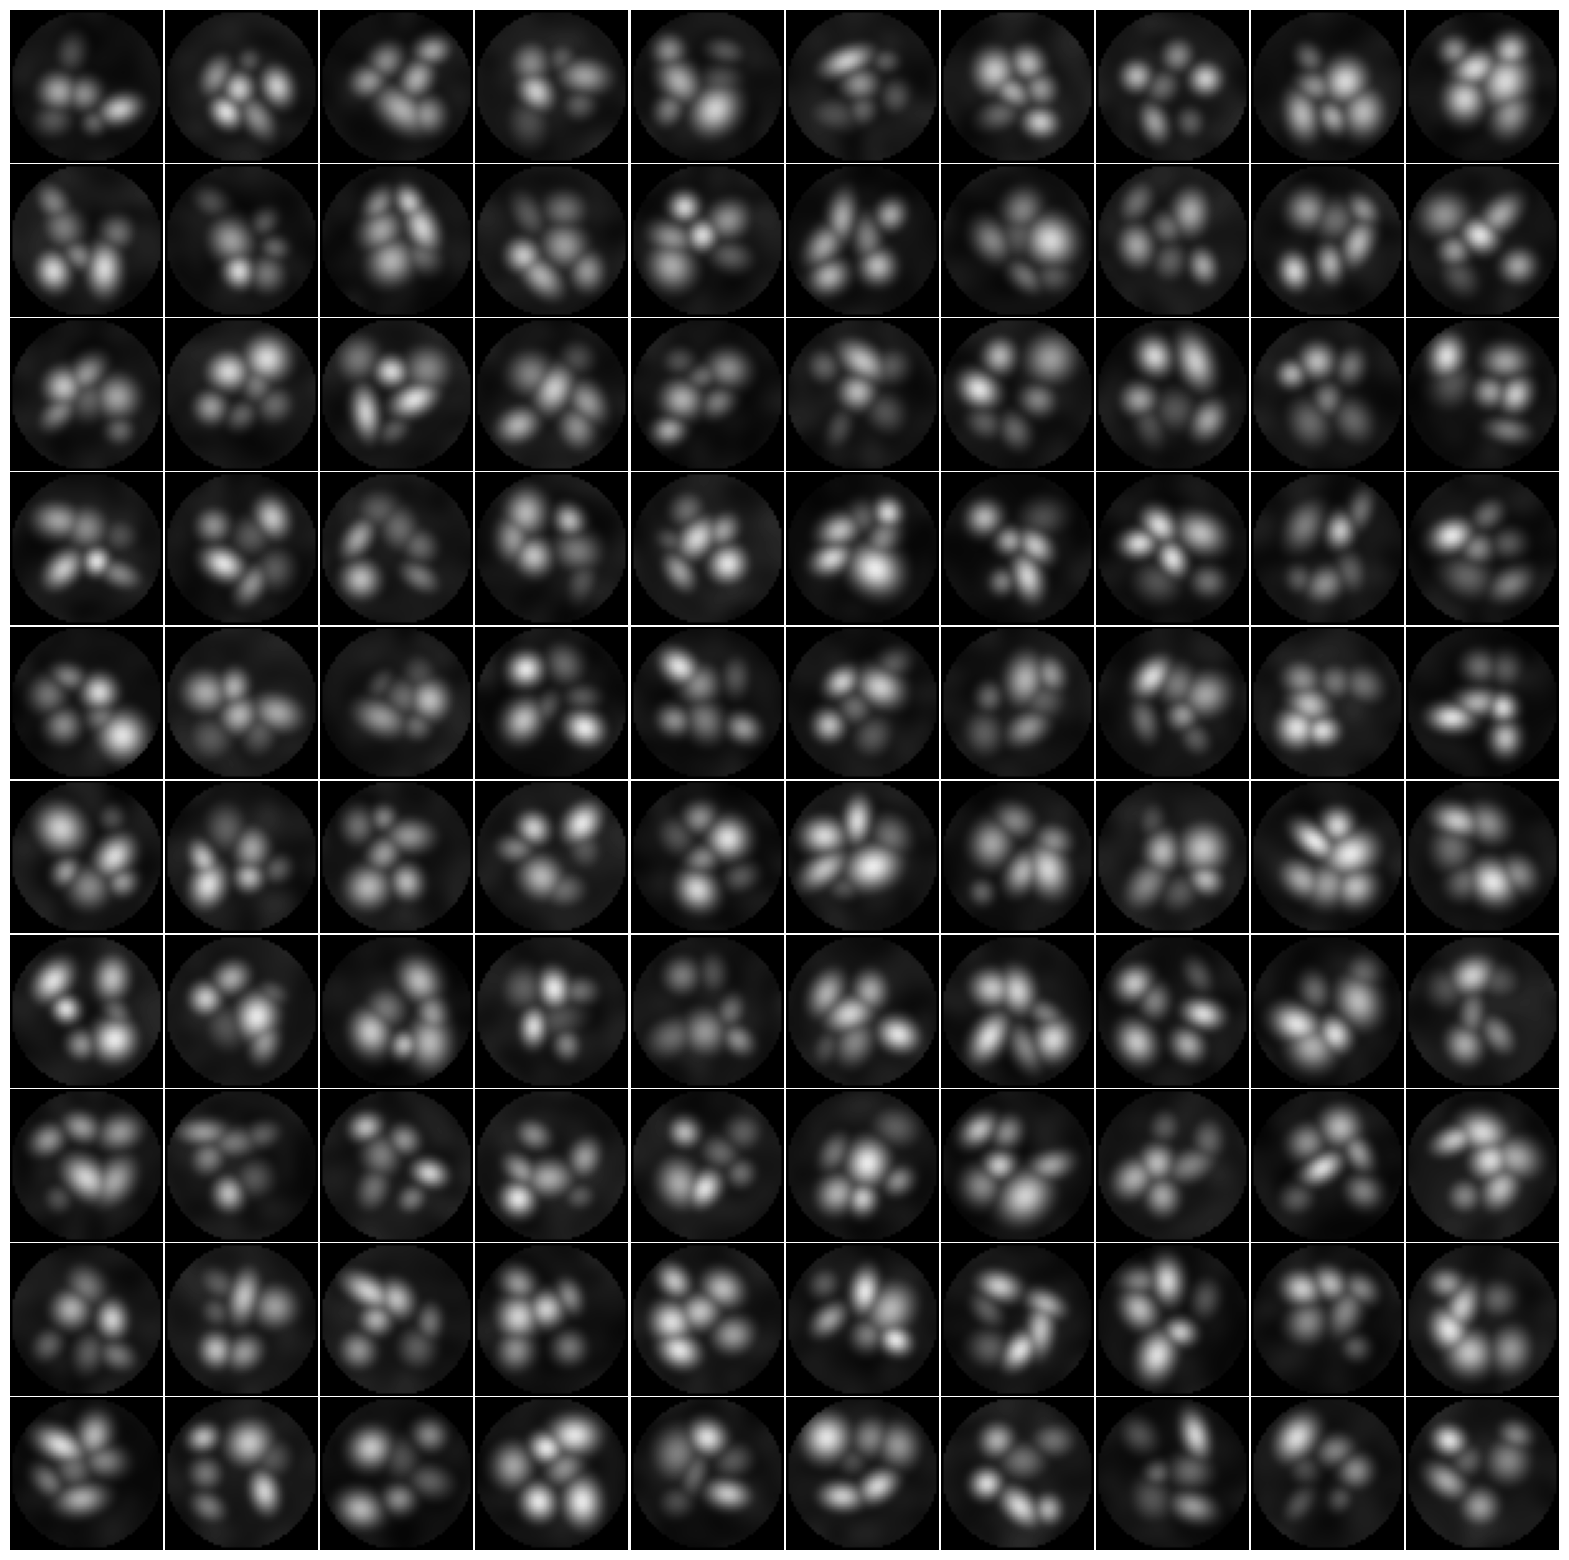

In [7]:
raw = [fake_ommatidia(n_photo=6, canvas_size=70, photo_size=40, spacing=10) for i in range(100)]
vign = [fake_vignette(im, lb, crop_width=5, vignette=True) for im, lb in raw]

f,a = plt.subplots(ncols=10, nrows=10, figsize=(20, 20), 
        gridspec_kw=dict(wspace=0.01, hspace=0.01))

for k in range(100):
    i, j = k % 10, k // 10
    a[i, j].axis("off")
    a[i, j].imshow(vign[k][0], vmin=0, vmax=1, cmap="gray")


In [10]:
RES_DIR = "../../res/fake_vignette"
IMGS = f"{RES_DIR}/imgs"
makedirs(RES_DIR, exist_ok=True)
makedirs(IMGS, exist_ok=True)

cat = list(range(1, 9))
annots = pd.DataFrame(columns=["filename", "class", "xmin", "ymin", "xmax", "ymax"])
N = 100

for i in cat:
    # make N fake img per number of photoreceptor (1 to 8)
    for j in range(N):
        try:
            # try to get fake ommatidia
            im_raw, lb_raw = fake_ommatidia(n_photo=i, canvas_size=70, photo_size=40, spacing=10)
        except:
            print(f"failure with fake ommatidia and n_photo={i}, pass")
            continue

        # transform fake ommatidia to fake vignette
        im_vign, lb_vign = fake_vignette(im_raw, lb_raw, vignette=True, crop_width=5)
        
        # fake name
        rnd_name = np.random.randint(1_000_000, 9_999_999)
        im_filename = f"{rnd_name}_fake_{i}.png"

        # insert box coordinate into a df
        df_box = get_boxes(lb_vign, im_filename)
        annots = pd.concat([annots, df_box], ignore_index=True)

        # save image 
        imsave(f"{IMGS}/{im_filename}", img_as_ubyte(im_vign))
        print(f"cat {i}, ({j+1}/{N}), {IMGS}/{im_filename} saved!")

# save df 
annots.to_csv(f"{RES_DIR}/annotations.csv", sep=",", index=False)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html